훈련 데이터 개수: 60000
테스트 데이터 개수: 10000


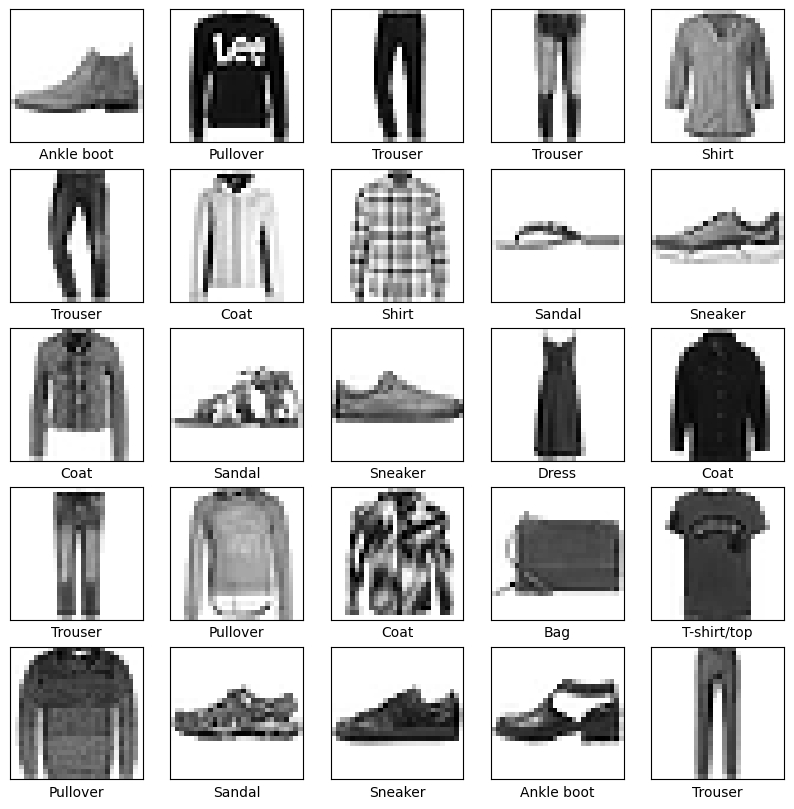

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gzip
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import umap
from sklearn.metrics import accuracy_score

# test labels 로드 
with gzip.open('./t10k-labels-idx1-ubyte.gz', 'rb') as lbpath:
    test_labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

# test images 로드't10k-images-idx3-ubyte.gz'
with gzip.open('./t10k-images-idx3-ubyte.gz', 'rb') as imgpath:
    test_images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(test_labels), 28, 28)

# Fashion-MNIST 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = TensorDataset(torch.from_numpy(test_images).unsqueeze(1).float() / 255, torch.from_numpy(test_labels))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 데이터 탐색
print("훈련 데이터 개수:", len(train_data))
print("테스트 데이터 개수:", len(test_data))

# 이미지 데이터 시각화
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap='binary')
    plt.xlabel(class_names[test_labels[i]])
plt.show()



Epoch 1, Loss: 1.6796, Accuracy: 0.7938
Epoch 2, Loss: 1.6010, Accuracy: 0.8667
Epoch 3, Loss: 1.5840, Accuracy: 0.8826
Epoch 4, Loss: 1.5745, Accuracy: 0.8912
Epoch 5, Loss: 1.5672, Accuracy: 0.8986


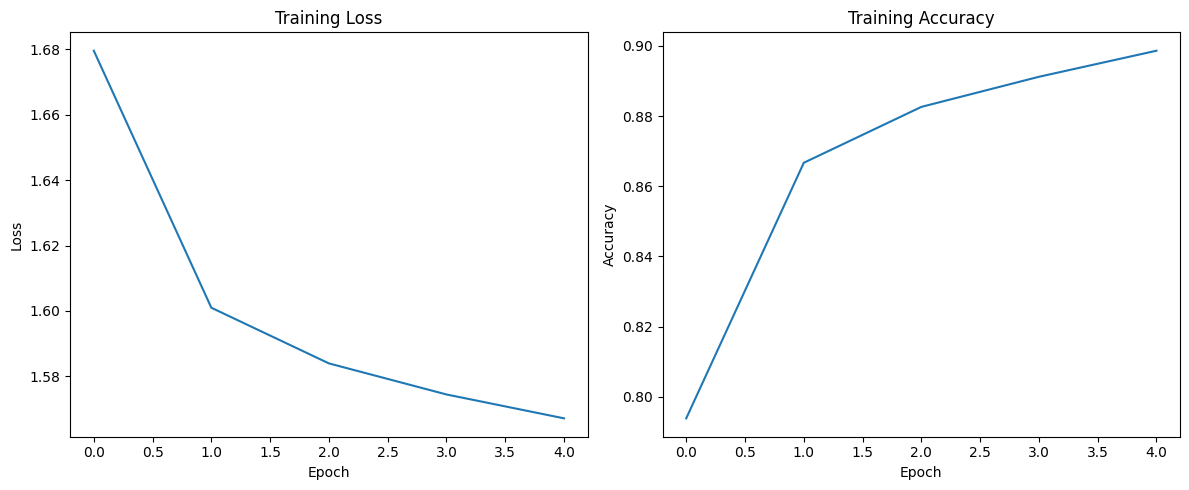

테스트 정확도: 0.8884


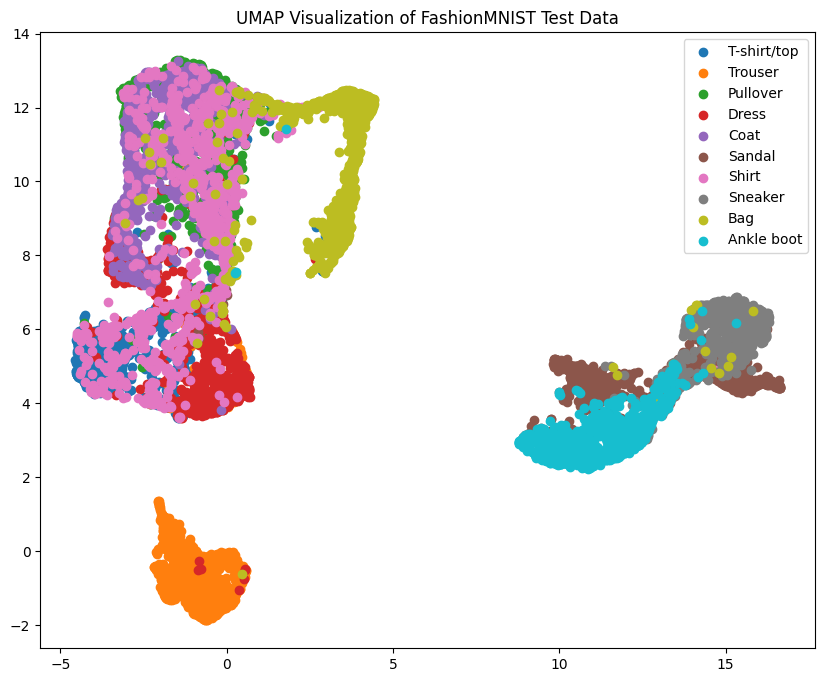

In [31]:
# 모델 구축
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(5408, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = x.view(-1, 5408)
        x = nn.functional.softmax(self.fc(x), dim=1)
        return x

model = Net()

# 모델 컴파일
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 모델 훈련 및 손실, 정확도 값 수집
losses = []
accuracies = []
for epoch in range(5):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

# 훈련 손실과 정확도 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# 모델 평가
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print('테스트 정확도:', accuracy)

# UMAP를 사용하여 이미지 데이터를 2차원으로 축소
reducer = umap.UMAP()
embedding = reducer.fit_transform(test_images.reshape(len(test_labels), -1))
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(embedding[test_labels == i, 0], embedding[test_labels == i, 1], label=class_names[i])
plt.title('UMAP Visualization of FashionMNIST Test Data')
plt.legend()
plt.show()

가장 잘못 매칭된 클래스는: Shirt


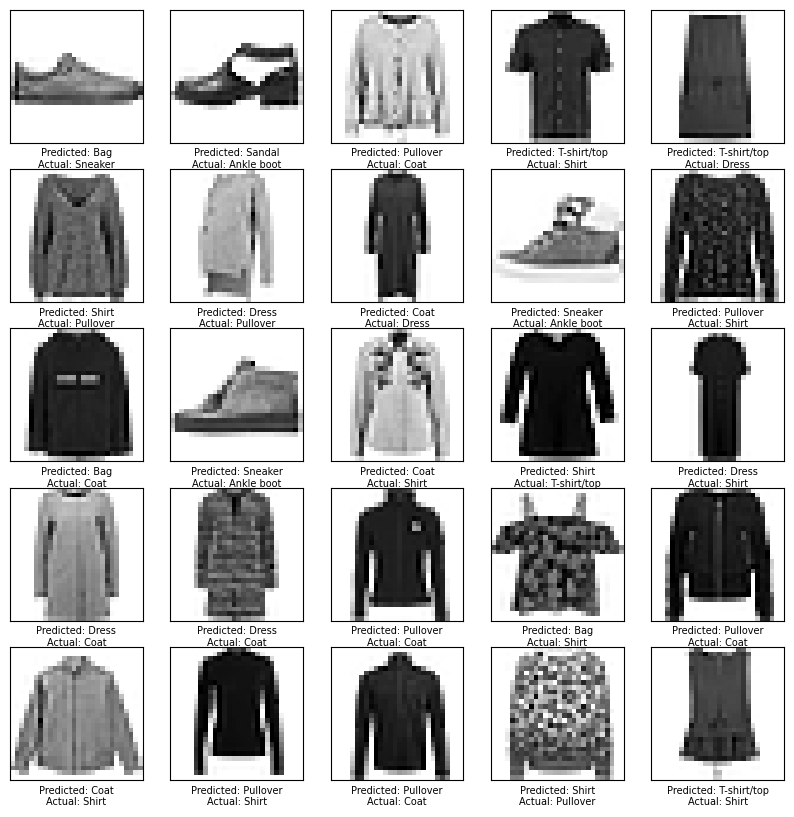

In [32]:
# 모델 예측
model.eval()
predictions = []
true_labels = []
for images, labels in test_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.numpy())
    true_labels.extend(labels.numpy())

# 잘못 분류된 이미지 찾기
misclassified_indexes = np.where(np.array(predictions) != np.array(true_labels))[0]

# 잘못 분류된 이미지 및 예측값 시각화
plt.figure(figsize=(10, 10))
for i, index in enumerate(misclassified_indexes[:25]):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data.tensors[0][index].squeeze(), cmap='binary')
    plt.xlabel(f'Predicted: {class_names[predictions[index]]}\nActual: {class_names[true_labels[index]]}', fontsize=7, wrap=True)

# 잘못 분류된 클래스 식별
misclassified_classes = [class_names[true_labels[index]] for index in misclassified_indexes]
most_common_misclassified_class = max(set(misclassified_classes), key=misclassified_classes.count)
print(f"가장 잘못 매칭된 클래스는: {most_common_misclassified_class}")